#Setup

In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
 
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from PIL import Image
import pandas as pd

from IPython import display
import cv2
import pickle

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= vid_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            print(video_path)
            break
 
            
    return frames_list

In [4]:
def create_data(input_dir):
    X = []
    Y = []
    ff=0
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
          ff=ff+1
          frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
          #print(len(frames))
          ac =0
          while ac <= vid_len:
            if len(frames[ac:ac+seq_len]) == seq_len:
                  X.append(frames[ac:ac+seq_len])
                  y = [0]*len(classes)
                  y[classes.index(c)] = 1
                  Y.append(y)
            ac=ac+seq_len
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    print(ff)
    return X, Y

#Data Set

In [5]:
import tensorflow as tf
data_dir = "/content/drive/MyDrive/data_yet_another/"
img_height , img_width = 60,80
seq_len = 10
vid_len=600 
classes = ["nw","ww"]
X, Y = create_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

ww
nw
16


In [6]:
X_train.shape

(768, 10, 80, 60, 3)

In [7]:
train_images = X_train.astype('float32')
test_images = X_test.astype('float32')

train_images /= 255.
test_images /= 255.

In [8]:
test_images.shape

(192, 10, 80, 60, 3)

In [9]:
train_images= train_images.reshape(7680,80,60,3)
test_images = test_images.reshape(1920,80,60,3)

In [10]:
batch_size = 64
train_size = len(train_images)
test_size = len(test_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [66]:
train_dataset

<BatchDataset shapes: (None, 80, 60, 3), types: tf.float32>

In [70]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [11]:
writer = tf.summary.create_file_writer('./new_loss')

In [12]:
device_name = tf.test.gpu_device_name()

#VAE Coding

In [18]:
#The Convolutional Variational Auto-Encoder Proper. 
#Define the network class

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):   #latent_dim is the dimensional of the latent space
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(80, 60, 3)),   #Note Input Image Size
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=128, kernel_size=3, strides=(1, 1), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=40*30*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(40,30, 32)), #Note the strides formula!
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=128,
                  kernel_size=3,
                  strides=(1, 1),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=3, kernel_size= 3, strides=(1, 1), padding="SAME", activation='sigmoid'),
            ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):   #encode the images into the latent space
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
    #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it 
    #by the latent distribution's variance 'rho'.

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [19]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    kl_tolerance = 0.5
    #import pdb; pdb.set_trace()
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_logit), axis=[1, 2, 3]))
    kl_loss = - 0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1)
    kl_loss = tf.reduce_mean(tf.maximum(kl_loss, kl_tolerance * latent_dim))
    loss_sum = reconstruction_loss + kl_loss
    
    with writer.as_default():
        tf.summary.scalar('Graph of' + '_reconstruction_loss', reconstruction_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_kl_loss', kl_loss, step=epoch)
        tf.summary.scalar('Graph of' + '_loss_sum',loss_sum, step=epoch)
        writer.flush()
    return loss_sum, reconstruction_loss, kl_loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, r_loss, kl_loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return r_loss, kl_loss

In [20]:
epochs = 100
latent_dim = 128
num_examples_to_generate = 12

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [21]:

def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(16,16))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('./images{:04d}.png'.format(epoch))
    plt.show()

In [22]:
def test_image(latent_dim,test_img):
    test_img = test_img.reshape(1,80,60,3)   #Note the Image size here
    model = CVAE(latent_dim)
    encod, logvar = model.encode(test_img)
    repar = model.reparameterize(encod, logvar)
    img = model.decode(repar)
    img *= 255.
    img = np.squeeze(img)
    return plt.imshow(img)

#Training

Epoch: 100, Test set LOSS_sum: 67.73783111572266, reconstruction_loss: 3.6694443225860596, kl_loss: 64.06838989257812,time elapse for current epoch 11.420703649520874


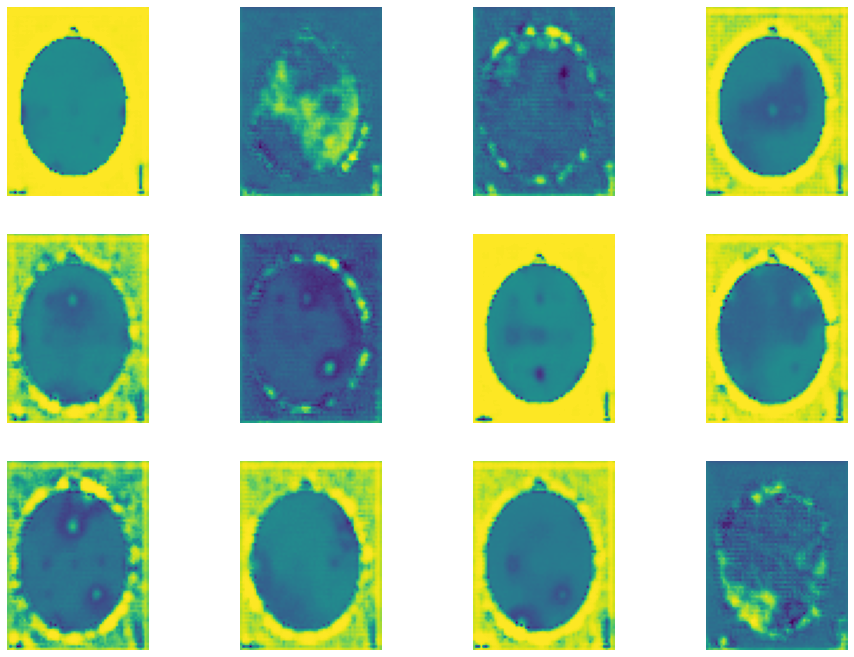

In [23]:
generate_and_save_images(model, 0, random_vector_for_generation)
df = pd.DataFrame()

losslist = []
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        r_loss, kl_loss = compute_apply_gradients(model, train_x, optimizer)
        #print(r_loss, kl_loss)
    end_time = time.time()

    if epoch % 1 == 0:
        #loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss_sum, rec_loss, kl_loss = compute_loss(model, test_x)
        losslist.append({'loss_sum':loss_sum.numpy(),'reconstruction_loss':rec_loss.numpy(),'kl_loss':kl_loss.numpy()})#append loss to list
        
        display.clear_output(wait=False)
        
        df = pd.DataFrame(losslist)  #append the dictionary to the dataframe
        df.to_csv('loss.csv')    #correct this

        print('Epoch: {}, Test set LOSS_sum: {}, reconstruction_loss: {}, kl_loss: {},'
              'time elapse for current epoch {}'.format(epoch,
                                                    loss_sum,rec_loss,kl_loss,
                                                    end_time - start_time))
    model.save_weights('my_model_weights.h5')
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

In [21]:
model.save_weights('my_model_weights.h5')

In [22]:
def display_image(epoch_no):
    return PIL.Image.open('./images{:04d}.png'.format(epoch_no))

(-0.5, 1151.5, 1151.5, -0.5)

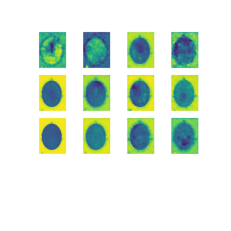

In [23]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

In [37]:
df = pd.read_csv('loss.csv',encoding = 'unicode_escape')
df = df.tail(300)

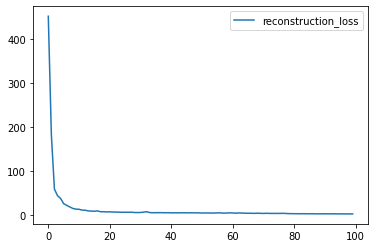

In [38]:
df.plot(y='reconstruction_loss')

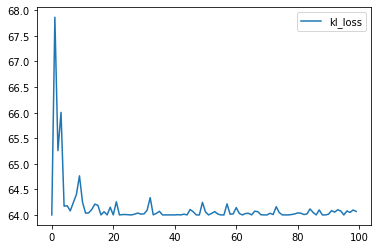

In [39]:
df.plot(y='kl_loss')

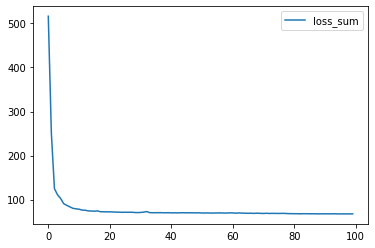

In [40]:
df.plot(y='loss_sum')

#Saved Weights

In [ ]:
import h5py
file_name = "/content/drive/MyDrive/VAE_DATA/my_model_weights.h5"
f = h5py.File(file_name, 'r')

In [ ]:
print(list(f.keys()))

['sequential', 'sequential_1']


In [24]:
def check_image(test_inputs,latent_dim):
    loaded_model = model
    test_inputs = test_inputs.reshape(1,80,60,3)
    encod, logvar = loaded_model.encode(test_inputs)
    repar = loaded_model.reparameterize(encod, logvar)
    img = loaded_model.decode(repar)
    #loss_sum, kl_loss, recon_loss = compute_loss(loaded_model, test_inputs)
    #print(loss_sum, kl_loss, recon_loss)
    img = np.squeeze(img)
    return img

In [25]:
through_encoder=[];
for img in train_images:
    through_encoder.append(check_image(img,10))


In [26]:
through_encoder_test=[];
for img in test_images:
    through_encoder_test.append(check_image(img,10))


In [27]:
through_encoder = np.asarray(through_encoder)
through_encoder_test=np.asarray(through_encoder_test)

In [28]:
through_encoder.shape
y_train.shape

(768, 2)

In [29]:
through_encoder=through_encoder.reshape(768,10,80,60,3)
#y_train
through_encoder_test=through_encoder_test.reshape(192,10,80,60,3)
#y_test

In [30]:
model_class = Sequential()

In [31]:
model_class.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(80,60,3)))
model_class.add(MaxPooling2D(pool_size=(2, 2)))
model_class.add(Dropout(0.25))
model_class.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model_class.add(BatchNormalization())
model_class.add(MaxPooling2D(pool_size=(2, 2)))
model_class.add(Dropout(0.25))
model_class.add(Flatten())
model_class.add(Dense(128, activation='relu'))
model_class.add(Dense(2, activation='softmax'))

In [32]:
model_kll = Sequential()
model_kll.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (10, 80, 60, 3)))
model_kll.add(Dropout(0.2))
model_kll.add(Flatten())
model_kll.add(Dense(256, activation="relu"))
model_kll.add(Dropout(0.3))


In [33]:
model_kll.add(Dense(2, activation = "softmax"))

In [91]:
model_kll.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 78, 58, 64)        154624    
_________________________________________________________________
dropout_5 (Dropout)          (None, 78, 58, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 289536)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               74121472  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 74,276,610
Trainable params: 74,276,610
Non-trainable params: 0
__________________________________________

In [34]:
model_kll.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [35]:
classify_train = model_kll.fit(through_encoder, y_train, batch_size=10,epochs=100,verbose=1,validation_data=(through_encoder_test, y_test))

Epoch 1/100
77/77 [==============================] - 22s 253ms/step - loss: 5.2138 - accuracy: 0.4579 - val_loss: 0.6687 - val_accuracy: 0.6354
Epoch 2/100
77/77 [==============================] - 19s 246ms/step - loss: 0.6750 - accuracy: 0.5910 - val_loss: 0.6721 - val_accuracy: 0.5521
Epoch 3/100
77/77 [==============================] - 19s 242ms/step - loss: 0.6722 - accuracy: 0.5817 - val_loss: 0.6822 - val_accuracy: 0.5833
Epoch 4/100
77/77 [==============================] - 19s 241ms/step - loss: 0.6795 - accuracy: 0.5791 - val_loss: 0.6580 - val_accuracy: 0.5625
Epoch 5/100
77/77 [==============================] - 19s 241ms/step - loss: 0.6512 - accuracy: 0.6050 - val_loss: 0.6220 - val_accuracy: 0.6562
Epoch 6/100
77/77 [==============================] - 19s 243ms/step - loss: 0.6070 - accuracy: 0.6916 - val_loss: 0.6138 - val_accuracy: 0.6250
Epoch 7/100
77/77 [==============================] - 19s 244ms/step - loss: 0.6071 - accuracy: 0.6556 - val_loss: 0.6358 - val_accuracy:

In [36]:
model_kll.save("model.h5")